In [ ]:
conda install -c conda-forge yfinance

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

### 1) algorithm trading

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
/var/folders/cj/5h760tr54tl8rq6rk6kx7pyw0000gn/T/ipykernel_37309/617699512.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][df['MA10'] > df['MA50']] = 1    #buy signal
/var/folders/cj/5h760tr54tl8rq6rk6kx7pyw0000gn/T/ipykernel_37309/617699512.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][df['MA10'] > df['MA50']] = 1    #buy signal
/var/folders/cj/5h760tr54tl8rq6rk6kx7pyw0000gn/T/ipykernel_37309/617699512.py:12: Set

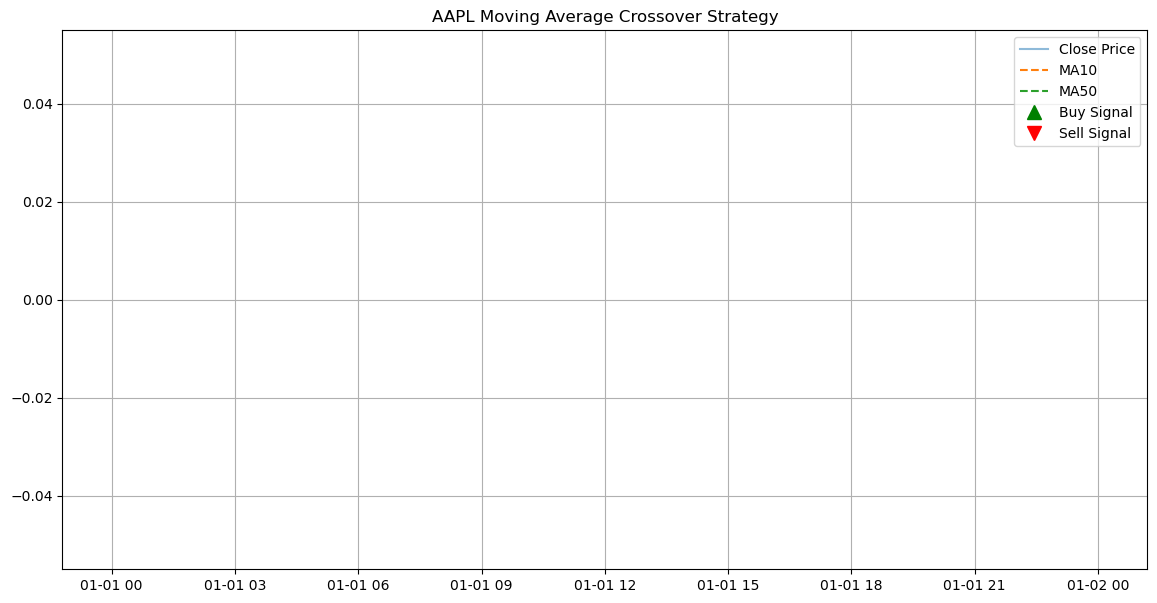

In [2]:
# Step 1: Download historical data
ticker = "AAPL"
df = yf.download(ticker, start="2022-01-01", end="2024-12-31")

# Step 2: Calculate moving averages
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Step 3: Generate trading signals
df['Signal'] = 0
df['Signal'][df['MA10'] > df['MA50']] = 1    #buy signal
df['Signal'][df['MA10'] < df['MA50']] = -1   #sell signal
df['Position'] = df['Signal'].shift(1)  
# Delay to avoid lookahead bias (as we using the close price, take the the trade position after close, the next day) 

# Step 4: Plot the signals
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA10'], label='MA10', linestyle='--')
plt.plot(df['MA50'], label='MA50', linestyle='--')
plt.plot(df[df['Position'] == 1].index, df['Close'][df['Position'] == 1], '^', color='g', label='Buy Signal', markersize=10)
plt.plot(df[df['Position'] == -1].index, df['Close'][df['Position'] == -1], 'v', color='r', label='Sell Signal', markersize=10)
plt.title(f'{ticker} Moving Average Crossover Strategy')
plt.legend()
plt.grid(True)
plt.show()

### 2) model calibration

In [ ]:
#the momentum position is arbitrary, calibrate the model to find the historically best value 

best_sharpe = -float('inf')
best_short = None
best_long = None

for short in range(5, 31, 5):      # Try 5, 10, 15, ..., 30
    for long in range(40, 101, 10):  # Try 40, 50, ..., 100
        if short >= long:
            continue
        
        df['MA_short'] = df['Close'].rolling(window=short).mean()
        df['MA_long'] = df['Close'].rolling(window=long).mean()
        
        df['Signal'] = 0
        df.loc[df['MA_short'] > df['MA_long'], 'Signal'] = 1
        df.loc[df['MA_short'] < df['MA_long'], 'Signal'] = -1
        df['Position'] = df['Signal'].shift(1)
        
        df['Returns'] = df['Close'].pct_change() #daily % return
        df['Strategy'] = df['Position'] * df['Returns'] #strategy return

        #use sharpe ratio to evaluate the performance
        sharpe = df['Strategy'].mean() / df['Strategy'].std() * (252**0.5)

        #take the best combo
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_short = short
            best_long = long

print(f"Best parameters: short={best_short}, long={best_long}, Sharpe={best_sharpe:.2f}")
